In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from os import chdir
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split

import pickle
from IPython.display import clear_output

In [2]:
#планируется словарь алгоритмов для более быстрого создания всех датафреймов
alg_dict = {'sort': ['bubble_sort', 'quicksort'], 'find': ['binary_search']}

In [3]:
#создание датафрейма
def make_df():
    df = pd.read_csv(f'csv/dataset.csv')
    df = df.set_index('filename')
    del df['Unnamed: 0']
    return df

In [4]:
def classification_sort(df):
    df = df[df['algorithm'] == 'sort']
    sort_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        if algorithm_name == 'bubble_sort':
            sort_class.append([1,0])
        else:
            sort_class.append([0,1])
    return df, sort_class

In [5]:
def classification_find(df):
    df = df[df['algorithm'] == 'find']
    sort_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        if algorithm_name == 'bubble_sort':
            sort_class.append([1,0])
        else:
            sort_class.append([0,1])
    return df, sort_class

In [6]:
def file_read(df):
    new_lines = []
    #df = df.sort_values(by='filename')
    for index, row in df.iterrows():
        chdir(f'dataset/{row[1]}/{row[2]}')
        with open(str(index),'r', encoding = 'utf-8') as f:
            lines = f.readlines()
            lines = [line for line in lines if line.strip() != ""]
        %cd ../../..
        new_lines.append(lines)
    #%cd ../..
    return new_lines

In [7]:
#обработка переменной без табов, заменяя их на 2 пробела (Доработать)
def preporcessing_files(lines):
    new_lines = []
    code_line = ''
    for i in lines:
        for j in i:
            j = j.replace('    ', ' ')
            code_line += j
        new_lines.append(code_line)
    return new_lines

In [8]:
df = make_df()
df_sort, classes_sort = classification_sort(df)
#df_find, classes_find = classification_find(df)
files = file_read(df_sort)
pre_files = preporcessing_files(files)
clear_output()

# Основная часть, построение архитектуры

In [9]:
maxWord = 1000
max_text_len = 50
tokenizer = Tokenizer(num_words=maxWord, lower = True, split = ' ', char_level=False)
tokenizer.fit_on_texts(pre_files)
dist = list(tokenizer.word_counts.items())
data = tokenizer.texts_to_sequences(pre_files)
data_pad = pad_sequences(data,maxlen = max_text_len)

In [10]:
with open('files\\data.pickle', 'wb') as file:
    # сохраняем данные в файл
    pickle.dump(data, file)

In [11]:
with open('files\\pre_files.pickle', 'wb') as file:
    # сохраняем данные в файл
    pickle.dump(pre_files, file)

In [12]:
pre_files

['def bubble_sort(arr):\n has_swapped = True\n total_iteration = 0\n while (has_swapped):\n  has_swapped = False\n  for i in range(len(arr) - total_iteration - 1):\n   if arr[i] > arr[i + 1]:\n    arr[i], arr[i + 1] = arr[i + 1], arr[i]\n    has_swapped = True\n  total_iteration += 1\n return arr\n',
 'def bubble_sort(arr):\n has_swapped = True\n total_iteration = 0\n while (has_swapped):\n  has_swapped = False\n  for i in range(len(arr) - total_iteration - 1):\n   if arr[i] > arr[i + 1]:\n    arr[i], arr[i + 1] = arr[i + 1], arr[i]\n    has_swapped = True\n  total_iteration += 1\n return arr\ndef bubble_sort(arr):\n has_swapped = True\n while (has_swapped):\n  has_swapped = False\n  for i in range(len(arr) - 1):\n   if arr[i] > arr[i + 1]:\n    arr[i], arr[i + 1] = arr[i + 1], arr[i]\n    has_swapped = True\n return arr\n',
 'def bubble_sort(arr):\n has_swapped = True\n total_iteration = 0\n while (has_swapped):\n  has_swapped = False\n  for i in range(len(arr) - total_iteration - 1):

In [16]:
X = data_pad
Y = np.array(classes_sort)

In [17]:
model = Sequential([
    Embedding(maxWord, 64, input_length = max_text_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 128)           98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 212,354
Trainable params: 212,354
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss ='categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(0.0001))

In [21]:
train_data, val_data, train_class, val_class = train_test_split(X,Y, test_size=0.2)

In [22]:
history = model.fit(X,Y, batch_size = 32, epochs = 100)

Epoch 1/100
2/2 [==============================] - 5s 73ms/step - loss: 0.6930 - accuracy: 0.4038
Epoch 2/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6895 - accuracy: 0.8077
Epoch 3/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6870 - accuracy: 0.8269
Epoch 4/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6835 - accuracy: 0.8269
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.6804 - accuracy: 0.8269
Epoch 6/100
2/2 [==============================] - 0s 27ms/step - loss: 0.6773 - accuracy: 0.8269
Epoch 7/100
2/2 [==============================] - 0s 27ms/step - loss: 0.6735 - accuracy: 0.8269
Epoch 8/100
2/2 [==============================] - 0s 21ms/step - loss: 0.6701 - accuracy: 0.8269
Epoch 9/100
2/2 [==============================] - 0s 20ms/step - loss: 0.6657 - accuracy: 0.8269
Epoch 10/100
2/2 [==============================] - 0s 19ms/step - loss: 0.6613 - accuracy: 0.8269
Epoch 11/100
2/2 [=

2/2 [==============================] - 0s 9ms/step - loss: 0.0491 - accuracy: 1.0000
Epoch 85/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0400 - accuracy: 1.0000
Epoch 86/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0361 - accuracy: 1.0000
Epoch 87/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0340 - accuracy: 1.0000
Epoch 88/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0301 - accuracy: 1.0000
Epoch 89/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0273 - accuracy: 1.0000
Epoch 90/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0257 - accuracy: 1.0000
Epoch 91/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0242 - accuracy: 1.0000
Epoch 92/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0213 - accuracy: 1.0000
Epoch 93/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 1.0000
Epoch 94/100
2/2 [==============

KeyError: 'val_accuracy'

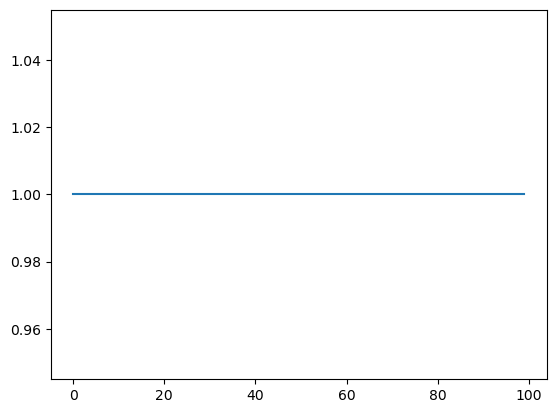

In [161]:
plt.plot(history.history['accuracy'],
         label='обучающий набор')
plt.plot(history.history['val_accuracy'],
         label='проверочный набор')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Тест моделей

In [36]:
# reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
# def seqence_to_text(list_of_indices):
#     return [reverse_word_map.get(letter) for letter in list_of_indices]

In [24]:
test_text = """
def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(0, n-i-1):
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr

arr = [64, 34, 25, 12, 22, 11, 90]
sorted_arr = bubble_sort(arr)
print("Sorted array:", sorted_arr)
            """.lower()
data_test = tokenizer.texts_to_sequences([test_text])
data_pad_test = pad_sequences(data_test, maxlen = max_text_len)
#print(seqence_to_text(data_test[0]))

In [25]:
res = model.predict(data_pad_test)
print(res, np.argmax(res))

[[6.1451533e-04 9.9938548e-01]] 1


In [39]:
model.save('models\\ещё_модель.h5')

# Вспомогательные функции

In [12]:
pwd

'C:\\Users\\Matvey\\Анализ кода\\Code-Insight\\dataset'

In [22]:
%cd Анализ кода/Code-Insight

C:\Users\Matvey\Анализ кода\Code-Insight


In [82]:
%cd ../..

C:\Users\Matvey\Анализ кода\Code-Insight


In [ ]:
%cd ../

In [ ]:
%cd ../../..